In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load CIFAR-10 dataset

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

y_train = y_train.squeeze()
y_test  = y_test.squeeze()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Simple CNN model (global model)

def create_cnn_model():
    model = keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ])
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

global_model = create_cnn_model()
global_model.summary()

# Split data across vehicles (clients) Option A (easier): IID split (random)

def split_iid(x, y, num_vehicles):
    idx = np.random.permutation(len(x))
    x, y = x[idx], y[idx]
    splits = np.array_split(np.arange(len(x)), num_vehicles)
    vehicle_data = []
    for s in splits:
        vehicle_data.append((x[s], y[s]))
    return vehicle_data

NUM_VEHICLES = 50
vehicle_data = split_iid(x_train, y_train, NUM_VEHICLES)

print("Vehicle 0 samples:", len(vehicle_data[0][0]))

# Assign vehicles to roadside BSs (edge servers)

NUM_BS = 5  # number of roadside base stations

# Simple: BS0 gets vehicles 0..9, BS1 gets 10..19, ...
vehicles_per_bs = [[] for _ in range(NUM_BS)]
for vid in range(NUM_VEHICLES):
    bs_id = vid % NUM_BS
    vehicles_per_bs[bs_id].append(vid)

for k in range(NUM_BS):
    print(f"BS{k} has vehicles:", vehicles_per_bs[k])

# Helper functions (local train + weighted aggregation)

# Local training on one vehicle
def train_one_vehicle(global_weights, x_local, y_local, local_epochs=1, batch_size=32):
    model = create_cnn_model()
    model.set_weights(global_weights)

    model.fit(
        x_local, y_local,
        epochs=local_epochs,
        batch_size=batch_size,
        verbose=0
    )
    return model.get_weights(), len(x_local)

# Weighted average of model weights (FedAvg-style)
def weighted_average(weights_list, sample_counts):
    """
    weights_list: list of model weights (each is a list of numpy arrays)
    sample_counts: how many samples each client (or BS) had
    """
    total = np.sum(sample_counts)
    avg = []
    for layer_i in range(len(weights_list[0])):
        layer_sum = 0.0
        for w, n in zip(weights_list, sample_counts):
            layer_sum += (n / total) * w[layer_i]
        avg.append(layer_sum)
    return avg

# One full HFL round (vehicles -> BS -> macro)

def run_one_hfl_round(global_model, vehicles_per_bs, vehicle_data, local_epochs=1):
    global_weights = global_model.get_weights()

    # ----- Edge level: each BS aggregates its vehicles -----
    edge_weights_list = []
    edge_sample_counts = []  # |D_k| for each BS

    for bs_id, vids in enumerate(vehicles_per_bs):
        local_weights_list = []
        local_sample_counts = []

        # vehicles train locally and upload to BS
        for vid in vids:
            x_local, y_local = vehicle_data[vid]
            w_local, n_local = train_one_vehicle(
                global_weights, x_local, y_local,
                local_epochs=local_epochs
            )
            local_weights_list.append(w_local)
            local_sample_counts.append(n_local)

        # BS edge aggregation (Eq. 18 style)
        w_edge = weighted_average(local_weights_list, local_sample_counts)
        edge_weights_list.append(w_edge)
        edge_sample_counts.append(np.sum(local_sample_counts))

    # ----- Macro level: macro aggregates edge models (Eq. 20 style) -----
    new_global_weights = weighted_average(edge_weights_list, edge_sample_counts)
    global_model.set_weights(new_global_weights)

    return global_model

# Train for multiple HFL rounds + evaluate

ROUNDS = 200
LOCAL_EPOCHS = 1

for r in range(1, ROUNDS + 1):
    global_model = run_one_hfl_round(
        global_model,
        vehicles_per_bs=vehicles_per_bs,
        vehicle_data=vehicle_data,
        local_epochs=LOCAL_EPOCHS
    )

    loss, acc = global_model.evaluate(x_test, y_test, verbose=0)
    print(f"Round {r:02d}: test accuracy={acc:.4f}, test loss={loss:.4f}")



(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Vehicle 0 samples: 1000
BS0 has vehicles: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
BS1 has vehicles: [1, 6, 11, 16, 21, 26, 31, 36, 41, 46]
BS2 has vehicles: [2, 7, 12, 17, 22, 27, 32, 37, 42, 47]
BS3 has vehicles: [3, 8, 13, 18, 23, 28, 33, 38, 43, 48]
BS4 has vehicles: [4, 9, 14, 19, 24, 29, 34, 39, 44, 49]
Round 01: test accuracy=0.1419, test loss=2.2835
Round 02: test accuracy=0.1581, test loss=2.2689
Round 03: test accuracy=0.1762, test loss=2.2519
Round 04: test accuracy=0.2067, test loss=2.2302
Round 05: test accuracy=0.2209, test loss=2.2026
Round 06: test accuracy=0.2432, test loss=2.1707
Round 07: test accuracy=0.2545, test loss=2.1347
Round 08: test accuracy=0.2717, test loss=2.0991
Round 09: test accuracy=0.2644, test loss=2.0693
Round 10: test accuracy=0.2853, test loss=2.0356
Round 11: test accuracy=0.3023, test loss=2.0109
Round 12: test accuracy=0.3013, test loss=2.0022
Round 13: test accuracy=0.3049, test loss=1.9754
Round 14: test accuracy=0.3065, test loss=1.9627
Round

In [2]:
# Plot accuracy & loss vs HFL rounds Cell A — modify your training loop to store history
import matplotlib.pyplot as plt

history_round = []
history_acc = []
history_loss = []

ROUNDS = 50
LOCAL_EPOCHS = 1

for r in range(1, ROUNDS + 1):
    global_model = run_one_hfl_round(
        global_model,
        vehicles_per_bs=vehicles_per_bs,
        vehicle_data=vehicle_data,
        local_epochs=LOCAL_EPOCHS
    )

    loss, acc = global_model.evaluate(x_test, y_test, verbose=0)
    print(f"Round {r:02d}: test accuracy={acc:.4f}, test loss={loss:.4f}")

    history_round.append(r)
    history_acc.append(acc)
    history_loss.append(loss)


Round 01: test accuracy=0.5923, test loss=1.1602
Round 02: test accuracy=0.5939, test loss=1.1589
Round 03: test accuracy=0.5928, test loss=1.1593
Round 04: test accuracy=0.5952, test loss=1.1576
Round 05: test accuracy=0.5934, test loss=1.1546
Round 06: test accuracy=0.5966, test loss=1.1516
Round 07: test accuracy=0.5977, test loss=1.1538
Round 08: test accuracy=0.5960, test loss=1.1492
Round 09: test accuracy=0.5966, test loss=1.1488
Round 10: test accuracy=0.5975, test loss=1.1464
Round 11: test accuracy=0.6000, test loss=1.1447
Round 12: test accuracy=0.5974, test loss=1.1440
Round 13: test accuracy=0.6020, test loss=1.1413
Round 14: test accuracy=0.5957, test loss=1.1458
Round 15: test accuracy=0.6022, test loss=1.1384
Round 16: test accuracy=0.6004, test loss=1.1363
Round 17: test accuracy=0.6020, test loss=1.1350
Round 18: test accuracy=0.6036, test loss=1.1347
Round 19: test accuracy=0.6044, test loss=1.1322
Round 20: test accuracy=0.6053, test loss=1.1314
Round 21: test accur

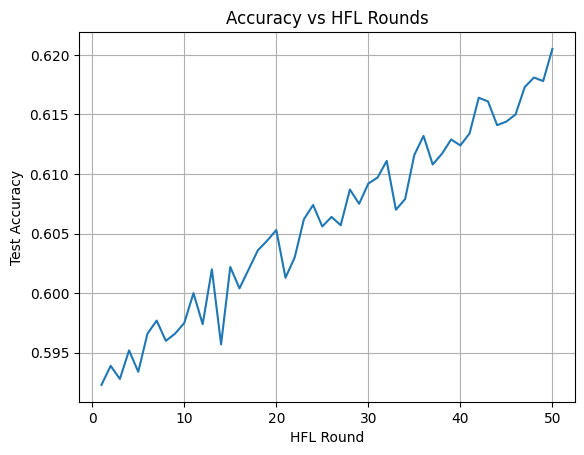

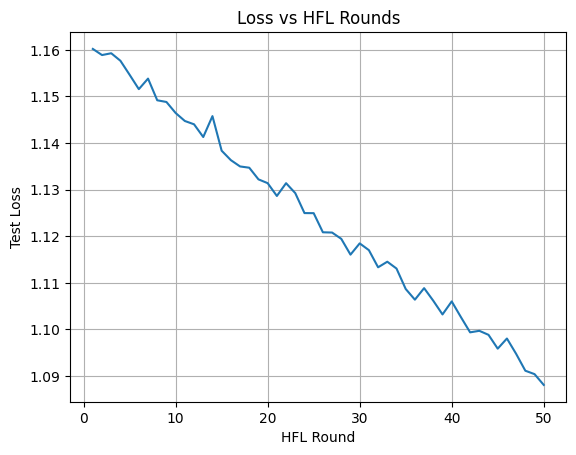

In [3]:
# Cell B — plot the curves
plt.figure()
plt.plot(history_round, history_acc)
plt.xlabel("HFL Round")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs HFL Rounds")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history_round, history_loss)
plt.xlabel("HFL Round")
plt.ylabel("Test Loss")
plt.title("Loss vs HFL Rounds")
plt.grid(True)
plt.show()


In [7]:
# Visualize the CNN architecture (layer diagram) Keras plot_model
from tensorflow.keras.utils import plot_model

plot_model(global_model, show_shapes=True, show_layer_names=True, expand_nested=True)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
